# Sentiment Analysis of Movie Reviews 

In [180]:
import pandas as pd
import numpy as np

import gensim


import dask.dataframe as dd
from dask.multiprocessing import get

### Read Data

In [176]:
df = pd.read_csv('../Misc/BagOfWords/labeledTrainData.tsv', sep='\t')

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [178]:
df.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


## Preprocessing Functions

In [228]:
import re
import string

import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer


def rem_html(text):
    """

    Removes html from text.

    :param text: raw text of type string including html statements
    :return: string without any html statements
    """

    return BeautifulSoup(text, 'html.parser').get_text()


def rem_stop(token_list, language='english', wordlist=[]):
    """

    Removes stopwords of a given language and a custom stopword list
    from a list of strings.

    :param token_list: list of strings
    :param language: language used to get stopword list from nltk. Default value is set to 'english'.
    :param wordlist: add a custom stopword list which could be specific to your case.
    :return: list of strings with removed stopword elements
    """

    return [word for word in token_list if word.lower() not in stopwords.words(language) + wordlist]


def get_stem(token_list):
    """
    Uses nltk stemming to stem words of a list.

    :param token_list: input list containing strings
    :return: list of strings where the elements have been stemmed.
    """
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(element) for element in token_list]


def rem_punctuation(text):
    """
    Removes chars contained in string.punctuation from each string.

    :param text: input string
    :return: string without any punctuation chars
    """
    
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    return regex.sub(' ', text)


def remove_additional_whitespaces(text):
    """
    Removes additional and trailing whitespaces from text.
    :param text: input text string
    :return: strings with additional and trailing whitespaces removed
    """

    return re.sub('\s+', ' ', text).strip()


def get_wordnet_pos(treebank_tag):
    """
    Translates treebank_tag to wordnet position in order to use lemmatizer.
    :param treebank_tag: penn treebank tag generated with nltk.pos_tag.
    :return: translated tag
    """

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


def get_lemma(token_list):
    """
    Lemmatizing words of a list.
    :param token_list: list of words
    :return: lemmatized list of words
    """

    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer('english')
    penn_treebank_tag_list = nltk.pos_tag(token_list)
    lemmatized = []
    for tuples in penn_treebank_tag_list:
        pos = get_wordnet_pos(tuples[1])
        if pos:
            lemmatized.append(lemmatizer.lemmatize(tuples[0], pos))
        else:
            lemmatized.append(stemmer.stem(tuples[0]))
    return lemmatized

In [326]:
def text_preprocess(text):
    text = rem_html(text)
    text = text.lower()
    text = rem_punctuation(text)
    text = remove_additional_whitespaces(text)
    text_list = nltk.word_tokenize(text)
    text_list = get_lemma(text_list)
    text_list = rem_stop(text_list)
    #text_list = tp.get_stem(text_list)
    return text_list

In [330]:
def series_preprocess(series):
    return series.apply(text_preprocess)

## Parallel Preprocessing with DASK

In [331]:
ddata = dd.from_pandas(df.review, npartitions=10)

In [332]:
ddata

Dask Series Structure:
npartitions=10
0        object
2500        ...
          ...  
22500       ...
24999       ...
Name: review, dtype: object
Dask Name: from_pandas, 10 tasks

In [334]:
%%time
res = ddata.map_partitions(series_preprocess).compute(get=get)

CPU times: user 1min 29s, sys: 1.38 s, total: 1min 30s
Wall time: 4min


In [335]:
df['review_preprocessed'] = res

In [337]:
df.head(20)

,id,sentiment,review,review_preprocessed
0,5814_8,1,With all this stuff going down at the moment w...,"[stuff, go, moment, mj, start, listen, music, ..."
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...","[classic, war, world, timothy, hines, entertai..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,"[film, start, manager, nicholas, bell, give, w..."
3,3630_4,0,It must be assumed that those who praised this...,"[must, assume, praise, film, great, filmed, op..."
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,"[superbly, trashy, wondrously, unpretentious, ..."
5,8196_8,1,I dont know why people think this is such a ba...,"[dont, know, whi, people, think, bad, movie, g..."
6,7166_2,0,"This movie could have been very good, but come...","[movie, could, good, come, way, short, cheesy,..."
7,10633_1,0,I watched this video at a friend's house. I'm ...,"[watch, video, friend, house, glad, waste, mon..."
8,319_1,0,"A friend of mine bought this film for £1, and ...","[friend, mine, bought, film, £1, even, grossly..."
9,8713_10,1,<br /><br />This movie is full of references. ...,"[movie, full, reference, like, mad, max, ii, w..."


In [338]:
df.to_pickle('reviews.pkl')

## Word Count

In [340]:
flat_array = np.concatenate(df.review_preprocessed).ravel()
unique, counts = np.unique(flat_array, return_counts=True)

In [342]:
word_counts_df = pd.DataFrame({'word': unique, 'count': counts}).sort_values(by='count', ascending=False)
word_counts_df.head()

,word,count
39455,movie,51685
21663,film,47920
42091,one,27736
36042,make,23093
34511,like,22291


## Word2Vec Model

In [344]:
from gensim.models import Word2Vec

In [479]:
model = Word2Vec(df.review_preprocessed, size=200, window=5, min_count=20, workers=12, iter=50)

In [460]:
vocab = list(model.wv.vocab)
X = model[vocab]

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [461]:
X

array([[-0.56341422,  0.79544038, -0.23643947, ...,  0.6633454 ,
         1.6484493 ,  1.87652755],
       [ 0.43913117,  1.136114  ,  0.63909292, ..., -1.58788109,
         0.43741837,  0.04629057],
       [-2.21335268, -1.64227128, -0.93464416, ...,  1.53142428,
        -1.84601521, -0.44274569],
       ..., 
       [-0.57959157,  3.10330272,  1.44882548, ..., -1.38015676,
         3.7922318 ,  0.71711236],
       [-0.81602496,  0.02326247,  0.02407342, ..., -2.15697408,
         0.66649699, -1.60273695],
       [-0.3043353 ,  0.78530353,  3.32609439, ...,  1.9827323 ,
         1.62430966, -2.94785666]], dtype=float32)

## Visualize Word2Vec

In [353]:
from sklearn.manifold import TSNE

In [355]:
%%time
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

CPU times: user 1min 5s, sys: 7.28 s, total: 1min 13s
Wall time: 1min 8s


In [361]:
df_tsne = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

In [362]:
df_tsne.to_pickle('df_tsne.pkl')

In [363]:
from matplotlib import pyplot as plt

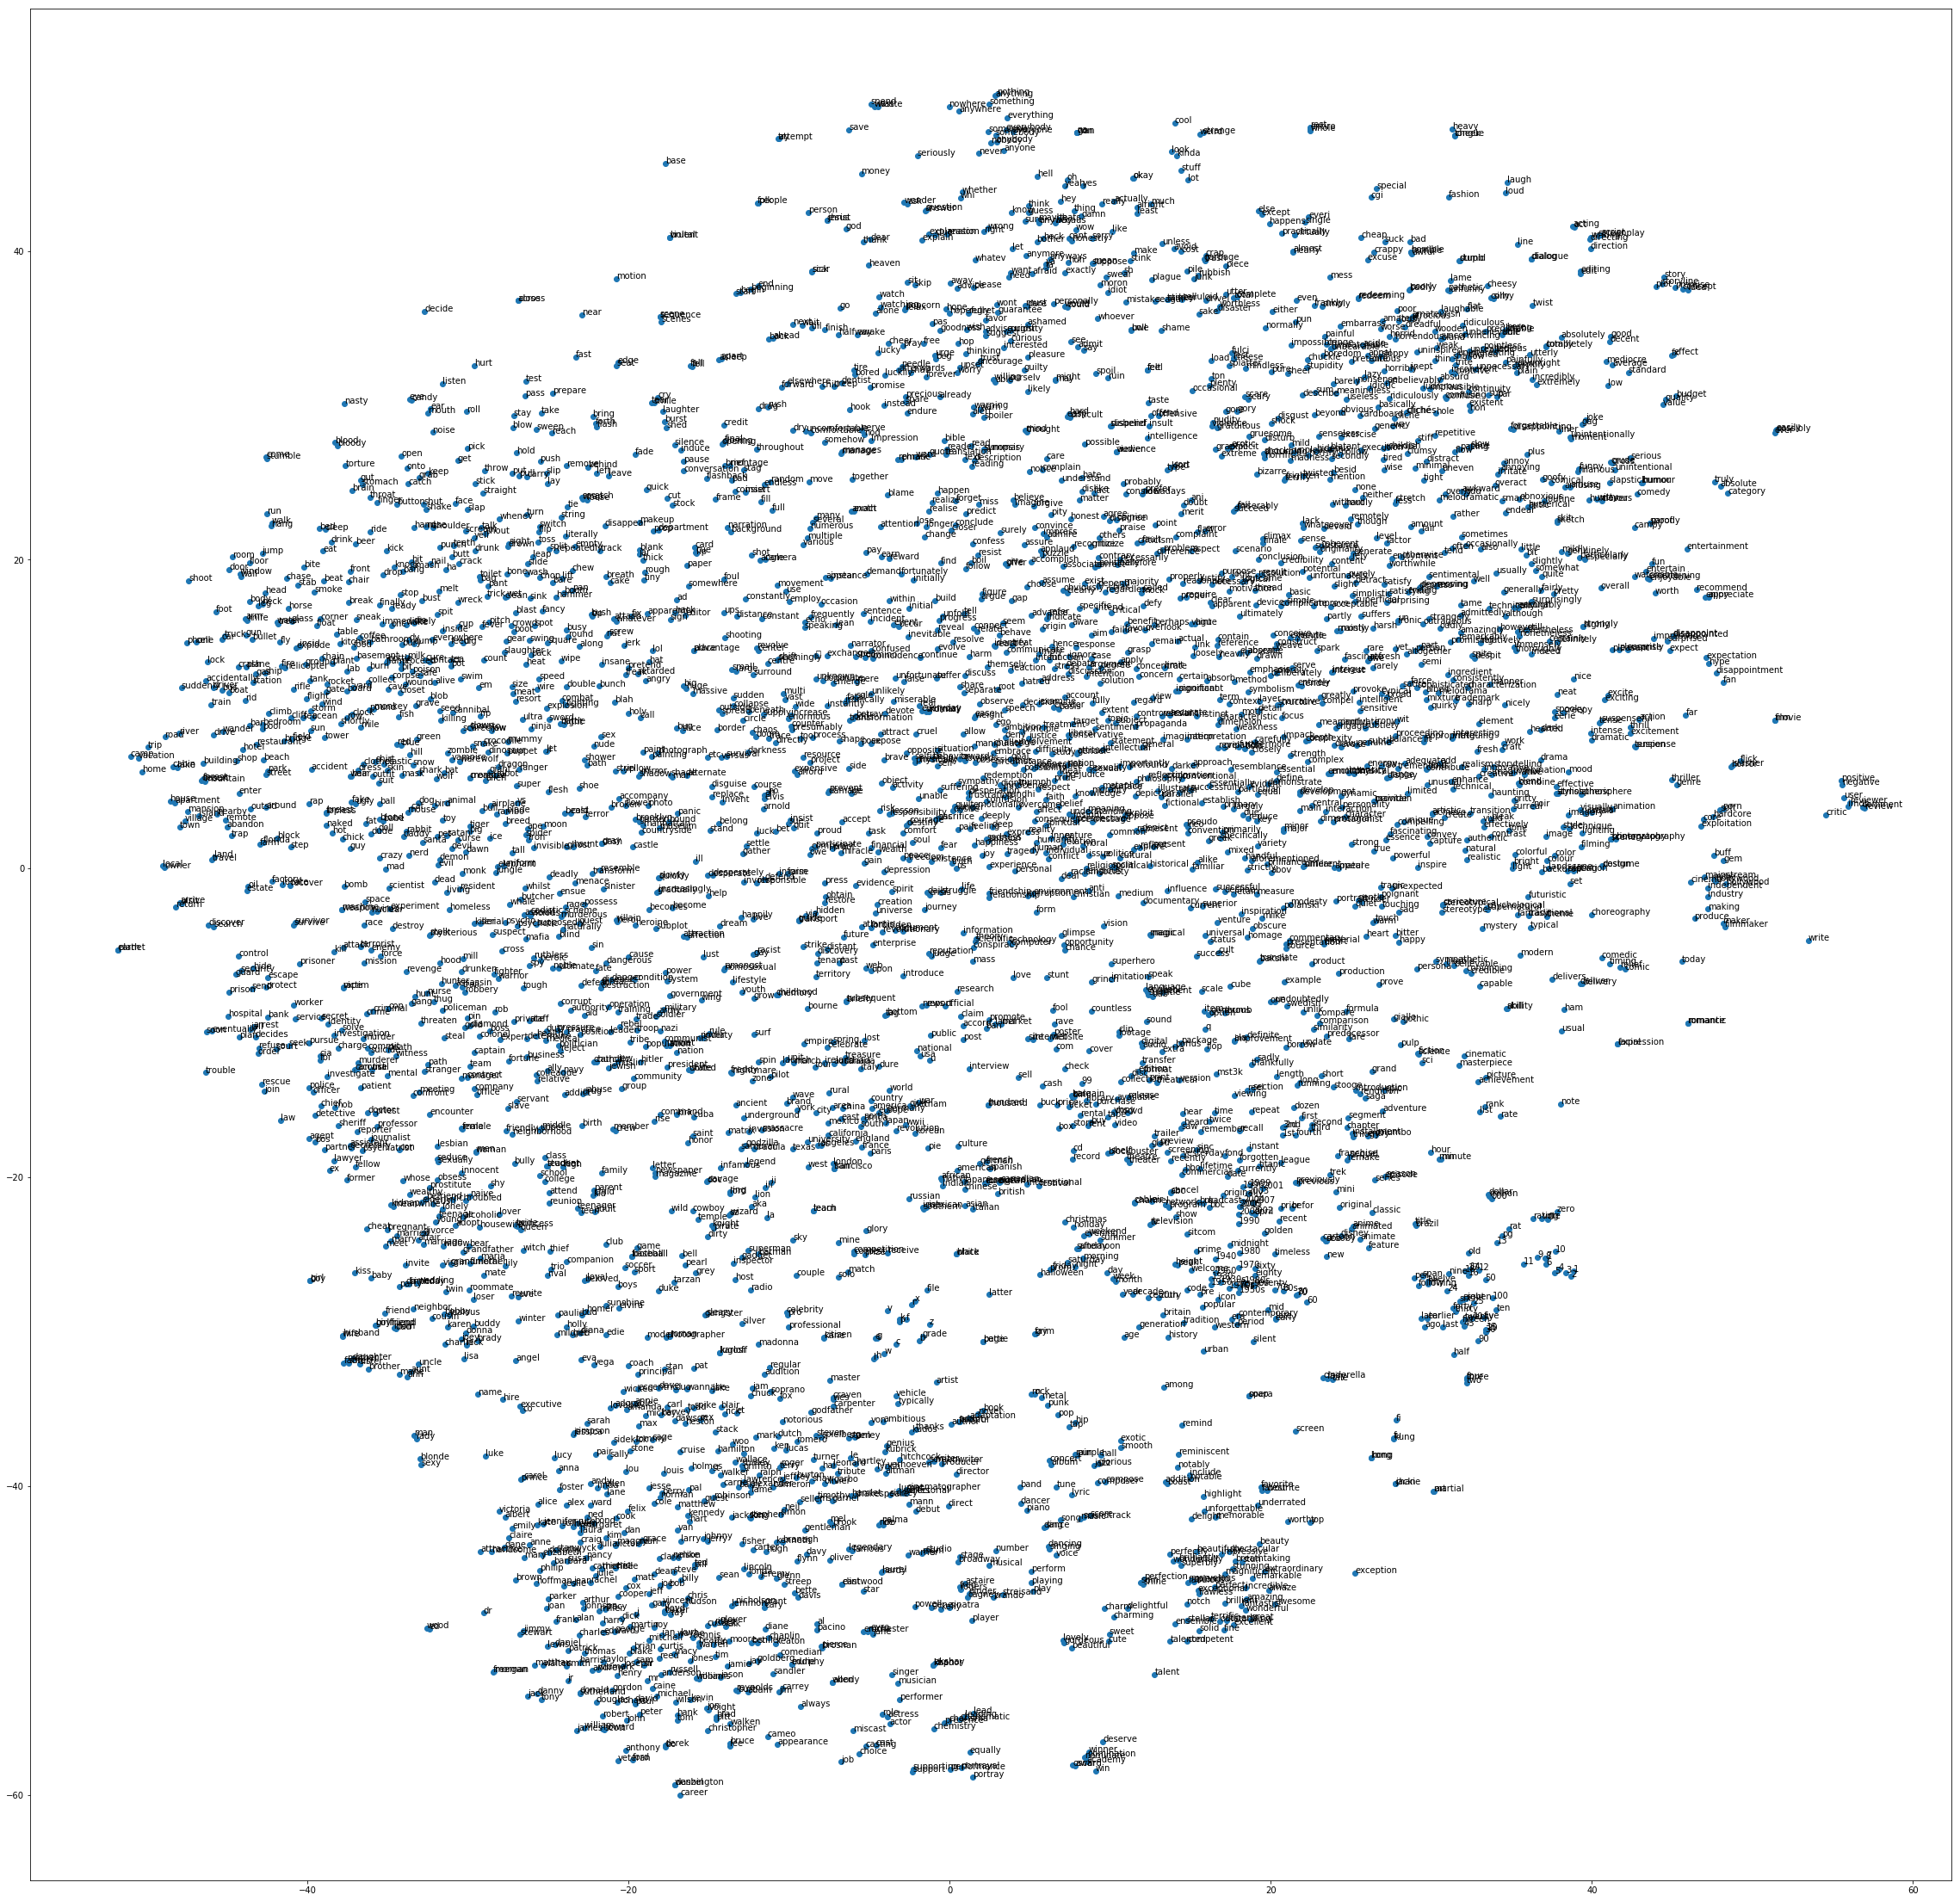

In [369]:
fig, ax = plt.subplots(figsize=(40,40))
ax.scatter(df_tsne['x'], df_tsne['y'])
for word, pos in df_tsne.iterrows():
    ax.annotate(word, pos)
fig.savefig('tsne_word2vec.png')

## Tfidf with WordEmbeddings
Next, we want to write our own Tfidf preprocessing. First, we compute the Tfidf weights for each word.

In [391]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

In [393]:
tfidf = TfidfTransformer()
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer(analyzer=lambda x:x)

In [395]:
tfidf_vectorizer.fit(df.review_preprocessed)

TfidfVectorizer(analyzer=<function <lambda> at 0x7ff6271bc730>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), norm='l2',
        preprocessor=None, smooth_idf=True, stop_words=None,
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [401]:
pd.Series(tfidf_vectorizer.vocabulary_).head()

stuff     56498
go        24609
moment    38882
mj        38682
start     55747
dtype: int64

In [ ]:
from itertools

In [420]:
list(w2v.values())[0]

array([ 1.2006799 , -0.32044566,  0.1943247 , -0.83457315,  0.30110598,
        0.07426669, -1.21594882, -1.65393245,  0.82488477,  0.8512345 ,
       -0.25983182,  1.12867725, -1.05129731, -0.34557667,  0.04511334,
       -0.60492569, -0.24427287,  0.32655135, -0.8505702 ,  0.80271161,
       -0.61544496, -0.33470225,  1.14217675,  0.05780092,  0.81330734,
       -1.20856142,  0.9266485 ,  0.62500864, -0.04944768, -0.74095589,
       -1.24945712,  1.05523562,  1.16856503,  1.58731544, -1.32066822,
        0.53420091, -0.51096594,  1.00820386,  0.51937032, -0.0578968 ,
       -0.76597285, -1.12128294, -2.39254022,  0.07239832,  0.55951726,
       -0.41364074,  0.61674821,  0.33084068, -0.21313985,  0.26994246,
        0.68364185,  0.32474929,  0.32418704,  0.01261404, -0.7276749 ,
        0.04071922,  1.31061101,  1.36002004, -0.1577321 ,  0.34923741,
       -0.38935131,  0.05281109, -0.33262032, -0.26106161,  0.6581583 ,
        0.3290886 ,  0.46497852,  0.6011762 , -0.11041089,  0.88

In [425]:
from collections import defaultdict
#collections.defaultdict(int)

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(list(w2v.values())[0])

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])


In [471]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [472]:
w2v_df = pd.DataFrame(w2v)
w2v_df.head()

,movie,film,one,make,like,see,good,get,time,character,...,package,woo,blond,composer,contest,loyal,counter,niro,1940,akshay
0,-1.193426,-1.422342,-0.300847,-0.704690,1.180777,-1.261644,0.582446,0.666988,-1.011245,-1.889246,...,2.021219,0.194425,-1.346610,1.029114,-0.026327,-0.298776,0.569097,2.142786,2.044291,0.268387
1,-0.154555,-0.670747,-0.614772,0.570767,1.262488,0.113545,1.443346,0.176188,0.218272,-1.116011,...,2.063102,1.205279,0.238000,2.692942,1.067186,-1.995792,0.236788,-1.153192,0.546064,-0.076983
2,-0.085375,-1.138213,-0.514947,-1.322599,-0.442371,-1.277957,1.149094,-0.528893,-0.695115,0.371763,...,0.313739,1.828225,-0.446496,-0.493470,-2.407652,0.819127,-0.618715,1.800458,-0.194191,-0.227001
3,-1.063767,0.199763,-0.711124,1.120524,0.554214,0.473386,0.254170,0.219014,0.213783,-0.065495,...,-0.413027,0.981180,-0.526676,0.125687,-1.370981,-0.904807,0.572410,0.005508,0.257797,-0.991831
4,0.668359,0.104333,0.797127,-0.409112,0.684093,0.095034,-0.024930,0.529180,0.566649,0.285543,...,-1.109954,-0.258227,-0.555318,-3.297908,-0.856996,0.627961,0.300358,0.151104,-0.748873,0.908112


In [473]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [474]:
X_train, X_test, y_train, y_test = train_test_split(df.review_preprocessed, df.sentiment, test_size=0.2, random_state=42)

In [475]:
test = TfidfEmbeddingVectorizer(w2v)

In [476]:
pipe = Pipeline([
    ('w2v', TfidfEmbeddingVectorizer(w2v)),
    ('rf', RandomForestClassifier(n_estimators=100))
])

In [477]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('w2v', <__main__.TfidfEmbeddingVectorizer object at 0x7ff625631b70>), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
     ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [478]:
pipe.score(X_test, y_test)

0.8256

In [456]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer=lambda x:x)),
    ('bayes', MultinomialNB())
])

In [457]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer=<function <lambda> at 0x7ff62607e7b8>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), norm='l2',
      ...e,
        vocabulary=None)), ('bayes', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [458]:
pipe.score(X_test, y_test)

0.86119999999999997